# q-learning

We try out $q$-learning with two very simple MDPs.

In [1]:
import random 
import numpy as np

import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

The q-learning algorithm. It follows an $\epsilon$-greedy policy.

In [2]:
# constant learning rate
def constant_rate_factory(learning_rate):
    return lambda i : learning_rate

# decaying learning rate
def power_rate_factory(eta0,decay):
    def learning_rate(i):
        return eta0/(1+i*decay)
    return learning_rate

# simple class that mimics spaces.Discrete from gym  
# provides discrete actions and a way to uniformly choose one of the actions
class DiscreteActionSpace:
    def __init__(self,n):
        self.n=n
    def sample(self):
        return random.randrange(0,self.n)

class Q_Learner:
    def __init__(self,env,learning_rate,epsilon=0.5,iterations=1000,record_state=None):
        """
        env: the RL environment, should work like in gym
        learning_rate: a function that, given the timestep i, returns the current learning rate
        epsilon: the epsilon for the epsilon-greedy policy
        iterations: run q-learning for this many iterations
        record_state: record q for this state, or None, if no recording desired
        """
        self.env=env
        self.epsilon=epsilon
        self.iterations=iterations
        self.learning_rate=learning_rate
        ### this is just to watch the progress of the algorithm
        self.record_state=record_state
        self.record=[[] for _ in range(self.env.action_space.n)]
        ### go!
        self.run()

    # I don't know how many states there are, so we make room for new ones
    # that we encounter
    def lazy_init_q(self,state):
        if state not in self.q:
            self.q[state]=[0]*self.env.action_space.n # initialise values to 0
            
    # simple epsilon greedy exploration strategy
    def eps_greedy(self,state,i):
        self.lazy_init_q(state) # ensure that self.q has an entry for the current state
        if random.random()<=self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.q[state])
    
    def run(self):
        self.q={}
        state,info=self.env.reset()
        for i in range(self.iterations):
            # eps-greedy chooses an action
            action=self.eps_greedy(state,i)
            # we get a new state and reward
            new_state,reward,done,truncated,info=self.env.step(action)
            self.lazy_init_q(new_state) # ensure that self.q has an entry for new state
            new_max_q=max(self.q[new_state])
            eta=self.learning_rate(i)
            # the update for the q-values
            self.q[state][action]=(1-eta)*self.q[state][action] + eta*(reward+new_max_q)
            ### this is just to watch the progress of the algorithm
            if self.record_state is not None:
                if state==self.record_state:
                    self.record[action].append((i,self.q[state][action]))
            state=new_state
            if done: # episode is over, start a new one
                state,info=self.env.reset()

    # convenience method to get policy based on q-values
    def policy(self):
        def best_policy(state):
            return np.argmax(self.q[state])
        return best_policy

# convenience method to plot evolution of q-values during progress of algorithm
def plot_record(records,title="",action_names=None):
    if action_names is None:
        action_names=["action 0","action 1"]
    _,ax=plt.subplots(figsize=(10,5))
    q_action0=np.array(records[0])
    q_action1=np.array(records[1])
    ax.plot(q_action0[:,0],q_action0[:,1],label=action_names[0])
    ax.plot(q_action1[:,0],q_action1[:,1],label=action_names[1])
    ax.set_xlabel("time step")
    ax.set_ylabel("q-value")
    ax.legend()
    ax.set_title(title)

## An extremely simple MDP

We first try q-learning with a very simple MDP. There are two starting states, 0 and 1, that are chosen with 50% chance each. There are two actions, 0 and 1,
and the epsiode is over after the first step. The rewards are as follows: if action == state, we have a 2/3 chance of winning a reward of 1, otherwise we receive -1. If action != state, we lose -1. It should be clear, what the best action is.

It's also clear what the true optimal $q$-values are:

* $q^*(0,0)=\frac{2}{3}\cdot 1+\frac{1}{3}\cdot(-1)=\frac{1}{3}$
* $q^*(0,1)=-1$
* $q^*(1,0)=-1$
* $q^*(1,1)=\frac{1}{3}$

The MDP I am going to implement will not inherit from the gym.Env class. Rather I will use [duck typing](https://en.wikipedia.org/wiki/Duck_typing) ("if it walks like a duck and quacks like a duck, it's a duck") to keep things simple. 

In [3]:
class Single_State_MDP:
    def __init__(self):
        self.action_space = DiscreteActionSpace(2)  # to make things compatible with gym
    def reset(self):
        self.state=random.randint(0,1)
        # gym.env.reset returns (state,info), and we do the same
        return (self.state,{})
    def step(self,action):
        if action!=self.state:
            # gym.env.step returns (state,reward,terminated,truncated,info), so we do the same
            return (42,-1,True,False,{})
        if random.random()<2/3:
            return (42,1,True,False,{})
        return (42,-1,True,False,{})
        
single_env=Single_State_MDP()
single_env.reset()

(1, {})

{0: [0.3402304864061336, -0.9948340736551462],
 42: [0, 0],
 1: [-0.991721692034989, 0.31941405771230713]}

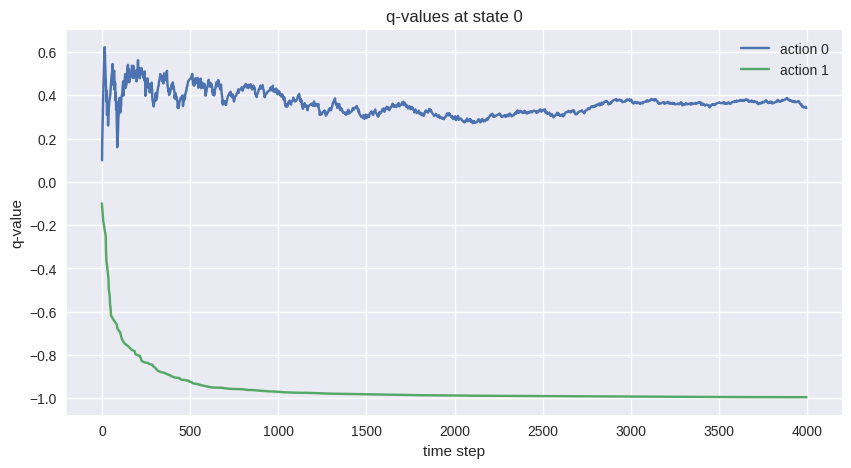

In [4]:
learning_rate=power_rate_factory(eta0=0.1,decay=0.01)
ql=Q_Learner(single_env,learning_rate=learning_rate,iterations=4000,record_state=0,epsilon=0.5)
plot_record(ql.record,title="q-values at state 0")
ql.q

{0: [0.34346331259716034, -0.9908298126519769],
 42: [0, 0],
 1: [-0.9942008645437761, 0.3577773384197044]}

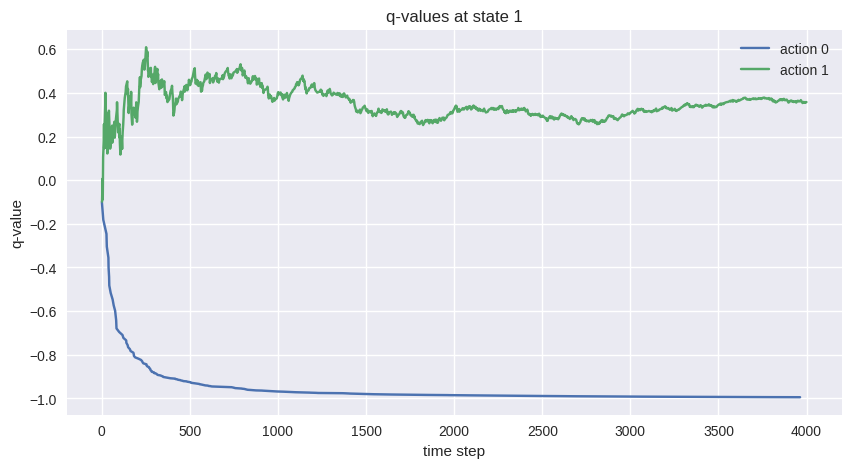

In [5]:
learning_rate=power_rate_factory(eta0=0.1,decay=0.01)
ql=Q_Learner(single_env,learning_rate=learning_rate,iterations=4000,record_state=1,epsilon=0.5)
plot_record(ql.record,title="q-values at state 1")
ql.q

$q$-values are converging, albeit slowly. This is quite remarkable as the environment could not be simpler.

## A two state MDP

Now let's look at another simple MDP. The starting state is state~$0$. The other other states are $-1,1$ and $2$. States $-1$ and $2$ are terminal states, with rewards $+1$ for state $-1$ and $+3$ for state $2$. State $1$ is not a terminal state and results in a penalty of $-1$. In each state, there are two actions possible, up or down. The action succeeds with 90% probability. That is, if we choose to go up, then with 90% probability the state is increased by $+1$, and with 10% probability the state is decreased by $-1$. The same holds for going down.

Obviously the best policy is to always move up. In expectation it will yield a total reward of close to 2. The second best policy is to move down, with a total reward of close to 1.

In [6]:
move_down=0
move_up=1
class Two_State_MDP:
    def __init__(self):
        self.action_space = DiscreteActionSpace(2)
    def reset(self):
        self.state=0
        # gym.env.reset returns (state,info), and we do the same
        return self.state,{}
    def step(self,action):
        if random.random()<0.9:
            move=2*action-1
        else:
            move=1-2*action
        self.state=self.state+move
        if self.state==-1:
            return (42,1,True,False,{})
        if self.state==0:
            return (self.state,0,False,False,{})
        if self.state==1:
            return (self.state,-1,False,False,{})
        if self.state==2:
            return (42,3,True,False,{})
                # gym.env.reset returns (state,info), and we do the same

two_env=Two_State_MDP()
two_env.reset()  # let's see what we get

(0, {})

{0: [1.0956431305689711, 1.7753084097604117],
 42: [0, 0],
 1: [1.9273780710222406, 2.8794710531656196]}

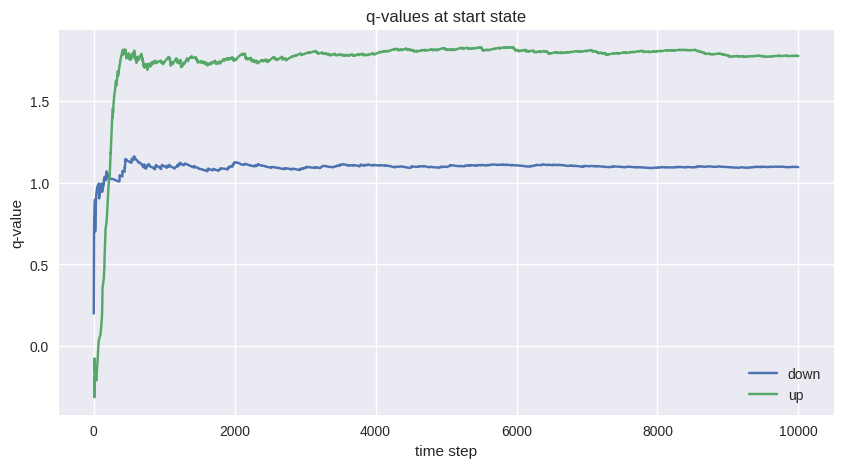

In [7]:
learning_rate=power_rate_factory(eta0=0.2,decay=0.01)

ql=Q_Learner(two_env,learning_rate=learning_rate,iterations=10000,record_state=0,epsilon=0.5)
plot_record(ql.record,title="q-values at start state",action_names=["down","up"])
ql.q

The $q$-values don't look too bad, and certainly indicate the right action. 

Try out $q$-learning for more complex MDPs -- I'll expect this to be challenging. 